In [49]:
try :
  from google.colab import drive
  IN_COLAB = True
except:
  IN_COLAB = False
print('IN COLAB: ', IN_COLAB)

IN COLAB:  True


In [50]:
import os
import pandas as pd

parentdir = "./propaganda_dataset_v2"
train_file= "propaganda_train.tsv"
val_file= "propaganda_val.tsv"

train_path=os.path.join(parentdir,train_file)
val_path=os.path.join(parentdir,val_file)

if IN_COLAB:
  train_path = '/content/propaganda_train.tsv'
  val_path = '/content/propaganda_val.tsv'

train_df=pd.read_csv(train_path,delimiter="\t",quotechar='|')
val_df=pd.read_csv(val_path,delimiter="\t",quotechar='|')


In [51]:
def transform_binaryify(row):
    new_value = 0 if row['label'] == 'not_propaganda' else 1
    return new_value

def transform_strip_tag(row):
    sent = row['tagged_in_context']
    cleaned_string = sent.replace("<BOS>", "")
    cleaned_string = cleaned_string.replace("<EOS>", "")
    return cleaned_string


train_df['propaganda'] = train_df.apply(transform_binaryify, axis=1)
# train_df['original_without_snip_tags'] = train_df.apply(transform_strip_tag, axis=1)


val_df['propaganda'] = val_df.apply(transform_binaryify, axis=1)
# val_df['original_without_snip_tags'] = val_df.apply(transform_strip_tag, axis=1)

train_df
val_df

,label,tagged_in_context,propaganda
0,not_propaganda,"On average, between 300 and 600 infections are...",0
1,causal_oversimplification,Mostly because <BOS> the country would not las...,1
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....,1
3,not_propaganda,<BOS> You <EOS> may opt out at anytime.,0
4,repetition,It must be exacted from him directly in order ...,1
...,...,...,...
635,not_propaganda,"NewsCatholic Church, <BOS> Family, Marriage <E...",0
636,not_propaganda,"Remember our saying, modern day fairy <BOS> ta...",0
637,not_propaganda,Why <BOS> not <EOS> open up to Iran with massi...,0
638,flag_waving,<BOS> He also sang an Islamic State fight song...,1


In [52]:
from torch.utils.data import DataLoader, Dataset
from transformers import BertModel, BertTokenizer
import torch
import numpy as np


class CustomPropagandaDataset_vanilla(Dataset):
    def __init__(self,df):
        tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

        self.labels=torch.tensor([label for label in df['propaganda']])
        self.texts=[tokenizer(text,padding='max_length',max_length=150,truncation=True,return_tensors="pt") for text in df['tagged_in_context']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self,idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self,idx):
        return self.texts[idx]

    def __getitem__(self,idx):
        batch_texts=self.get_batch_texts(idx)
        batch_y=self.get_batch_labels(idx)

        return batch_texts,batch_y


def prepare_inputs(input1,label,device):
  label=label.to(device)
  mask=input1['attention_mask'].to(device)
  input_id=input1['input_ids'].squeeze(1).to(device)
  return (input_id,mask,label)

In [53]:
train_data = CustomPropagandaDataset_vanilla(train_df)
val_data = CustomPropagandaDataset_vanilla(val_df)

In [54]:
train_dataloader=torch.utils.data.DataLoader(train_data,batch_size=50,shuffle=True)
val_dataloader=torch.utils.data.DataLoader(val_data,batch_size=50)

In [55]:
from torch import nn

class BertClassifier(nn.Module):

    def __init__(self,dropout=0.5,num_classes=2):
        super(BertClassifier, self).__init__()

        self.bert=BertModel.from_pretrained('bert-base-uncased')
        self.dropout=nn.Dropout(dropout)
        self.linear=nn.Linear(768,num_classes)
        self.relu=nn.ReLU()

    def forward(self,input_id,mask):

        _, pooled_output = self.bert(input_ids=input_id,attention_mask=mask,return_dict=False)
        dropout_output=self.dropout(pooled_output)
        linear_output=self.linear(dropout_output)
        final_layer=self.relu(linear_output)

        return final_layer

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [56]:
# wills
epochs = 3
lr = 5e-6
batch_size=50
max_len=150

100%|██████████| 52/52 [00:57<00:00,  1.11s/it]


Epochs: 1 | Train Loss: 0.014 | Train Accuracy: 0.557
Val loss: 0.013 | Val Accuracy: 0.662


100%|██████████| 52/52 [00:57<00:00,  1.10s/it]


Epochs: 2 | Train Loss: 0.013 | Train Accuracy: 0.657
Val loss: 0.011 | Val Accuracy: 0.750


100%|██████████| 52/52 [00:57<00:00,  1.11s/it]


Epochs: 3 | Train Loss: 0.012 | Train Accuracy: 0.726
Val loss: 0.011 | Val Accuracy: 0.727
______04ac2eaa-754d-46b5-a69c-cddd4e9e9f26______
LR: 5e-06 FINAL ACC = 0.727
LR: 5e-06 BEST ACC = 0.750
____________


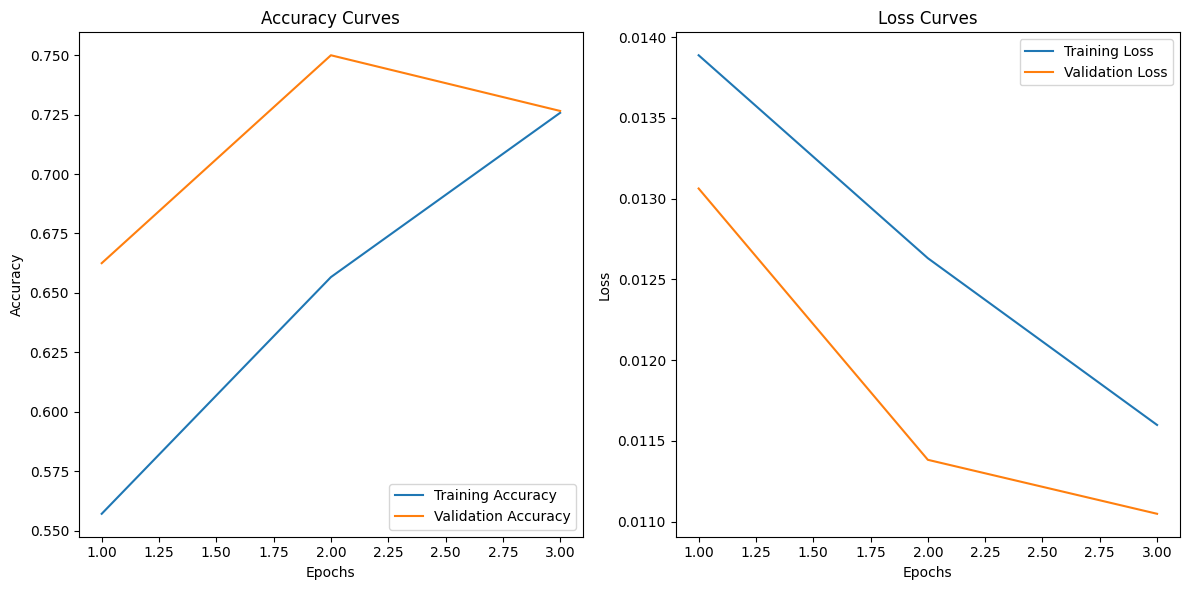

In [57]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import json
import uuid



model=BertClassifier(num_classes=2).to(device)
criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)


train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

best_val_acc = 0
best_epoch = 0
best_model_state = None

model_id = str(uuid.uuid4())


for epoch_num in range(epochs):


        total_acc_train=0
        total_loss_train=0
        model.train()
        
        for train_input,train_label in tqdm(train_dataloader):

            input_id,mask, train_label=prepare_inputs(train_input,train_label,device)

            output_1=model(input_id,mask)

            batch_loss_1=criterion(output_1,train_label.long())

            total_loss_train += batch_loss_1.item()

            acc=(output_1.argmax(dim=1)==train_label).sum().item()
            total_acc_train+=acc

            model.zero_grad()
            batch_loss_1.backward()
            optimizer.step()

        total_acc_val=0
        total_loss_val=0

        y_true = []
        y_pred = []
        model.eval()
        with torch.no_grad():
            for val_input,val_label in val_dataloader:

                input_id,mask, val_label=prepare_inputs(val_input,val_label,device)

                output_2= model(input_id,mask)

                # for scoring
                predicted = output_2.argmax(dim=1)
                y_true.extend(val_label.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

                batch_loss_2=criterion(output_2,val_label.long())

                total_loss_val+=batch_loss_2.item()

                acc=(output_2.argmax(dim=1)==val_label).sum().item()
                total_acc_val+=acc
                
            train_acc = total_acc_train / len(train_data)

        train_loss = total_loss_train / len(train_data)
        val_acc = total_acc_val / len(val_data)
        val_loss = total_loss_val / len(val_data)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

        print(f'Epochs: {epoch_num+1} | Train Loss: {total_loss_train / len(train_data):.3f} | Train Accuracy: {total_acc_train/len(train_data):.3f}')
        print(f'Val loss: {total_loss_val/len(val_data):.3f} | Val Accuracy: {total_acc_val / len(val_data):.3f}')
        if val_acc > best_val_acc:
          best_epoch = epoch_num
          y_true_best = y_true.copy()
          y_pred_best = y_pred.copy()
          best_val_acc = val_acc
          best_model_state = model.state_dict()

        if epoch_num == epochs-1:
            print(f'______{model_id}______')
            print(f'LR: {lr} FINAL ACC = {total_acc_val / len(val_data):.3f}')
            print(f'LR: {lr} BEST ACC = {best_val_acc:.3f}')
            print('____________')


# Plot the accuracy and loss curves over epochs
epochs_range = range(1, epochs+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc_list, label='Training Accuracy')
plt.plot(epochs_range, val_acc_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy Curves')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss_list, label='Training Loss')
plt.plot(epochs_range, val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Loss Curves')

plt.tight_layout()
plt.show()



# # Create a dictionary to store the results, hyperparameters, and model ID
# results_dict = {
#     'model_id': model_id,
#     'train_accuracy': train_acc_list,
#     'train_loss': train_loss_list,
#     'val_accuracy': val_acc_list,
#     'val_loss': val_loss_list,
#     'hyperparameters': {
#         'learning_rate': lr,
#         'num_epochs': epochs,
#         'batch_size': batch_size,
#         'max_len': max_len
#     },
#     'results': {
#         "last_acc": val_acc_list[-1],
#         'best_acc': best_val_acc,
#         'confusion_matrix': cm.tolist(),
#         'classification_report': report
#     }
# }

# # Save the results dictionary as a JSON file with the model ID
# results_filename = f'results_{model_id}.json'
# with open(results_filename, 'w') as f:
#     json.dump(results_dict, f, indent=4)

# # Save the best model state with the model ID
# model_filename = f'best_model_{model_id}.pth'
# torch.save(best_model_state, model_filename)

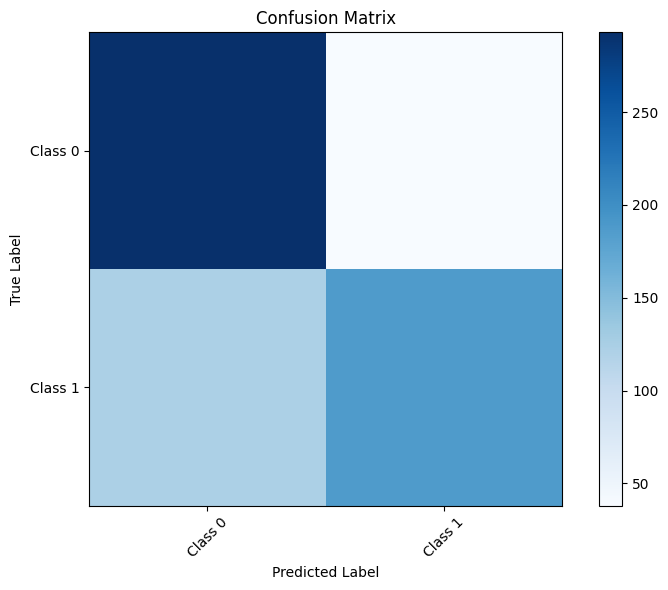

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.66      0.98      0.79       331
     Class 1       0.95      0.46      0.62       309

    accuracy                           0.73       640
   macro avg       0.80      0.72      0.70       640
weighted avg       0.80      0.73      0.71       640



In [58]:
# analysis of best performing model

cm = confusion_matrix(y_true_best, y_pred_best)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
classes = ['Class 0', 'Class 1']  # Replace with your class labels

# Compute precision, recall, F1-score, and other metrics for best one
report = classification_report(y_true, y_pred, target_names=classes)
print('Classification Report:')
print(report)
